In [104]:
import os
import copy
# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader

# Auxiliary Python imports
import numpy as np
from tqdm.notebook import tqdm

# Environment import and set logger level to display error only
import gym; gym.logger.set_level(40)
from gym.wrappers import Monitor

# Plotting and notebook imports
import matplotlib.pyplot as plt

from env import RandomAugmentingEnv

In [105]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Auxiliary Methods

In [106]:
def get_running_stat(stat, stat_len):
    # evaluate stats
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len


def plot_results(runner):
    # plot stats
    episode, r, l = np.array(runner.stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)
    
    plt.figure(figsize=(16, 16))

    plt.subplot(321)

    # plot rewards
    plt.plot(episode[-len(cum_r):], cum_r)
    plt.plot(episode, r, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
   
    plt.subplot(322)
    
    # plot episode lengths
    plt.plot(episode[-len(cum_l):], cum_l)
    plt.plot(episode, l, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    
    plt.subplot(323)
    
    # plot return
    all_returns = np.array(runner.buffer.all_returns)
    plt.scatter(range(0, len(all_returns)), all_returns, alpha=0.5)
    mean_returns = np.array(runner.buffer.mean_returns)
    plt.plot(range(0, len(mean_returns)), mean_returns, color="orange")
    plt.xlabel('Episode')
    plt.ylabel('Return')
    
    plt.subplot(324)
    
    # plot entropy
    entropy_arr = np.array(runner.stats_entropy_list)
    plt.plot(range(0, len(entropy_arr)), entropy_arr)
    plt.xlabel('Episode')
    plt.ylabel('Entropy')

    plt.subplot(325)

    if runner.logger.debug:
        # plot variance
        variance_arr = np.array(runner.logger.compute_gradient_variance())
        plt.plot(range(0, len(variance_arr)), variance_arr)
        plt.xlabel('Episode')
        plt.ylabel('Variance')
    
    plt.show()



def grad_variance(g):
    # compute gradient variance
    return np.mean(g**2) - np.mean(g)**2


class Logger(object):
    """Logger that can be used for debugging different values
    """
    def __init__(self, debug=False):
        self.gradients = []
        self.debug = debug

    def add_gradients(self, grad):
        if not self.debug: return
        self.gradients.append(grad)

    def compute_gradient_variance(self):
        vars_ = []
        grads_list = [np.zeros_like(self.gradients[0])] * 100
        for i, grads in enumerate(self.gradients):
            grads_list.append(grads)
            grads_list = grads_list[1:]
            grad_arr = np.stack(grads_list, axis=0)
            g = np.apply_along_axis(grad_variance, axis=-1, arr=grad_arr)
            vars_.append(np.mean(g))
        return vars_

### Test environment

OpenAI offers a set of environments for Reinforcement Learning, which are accessible via the `gym` pip package.
In this exercise we will focus on discrete control tasks using a Box2D simulation known as BipedalWalker-v3.
To access the Box2D packages, make sure you have installed gym via `pip install gym` and the Box2D simulator via `pip install box2d box2d-kengz` command in the terminal in advance.

In [107]:
# show behavior in envrionment with random agent
env = RandomAugmentingEnv(obs_position=20, floor_height=20)

### Training Buffer

In [108]:
class Transition(object):
    """Transition helper object
    """
    def __init__(self, state, action, reward, next_state, log_probs):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.g_return = 0.0
        self.log_probs = log_probs


class Episode(object):
    """Class for collecting an episode of transitions
    """
    def __init__(self, discount):
        self.discount = discount
        self._empty()
        self.total_reward = 0.0

    def _empty(self):
        self.n = 0
        self.transitions = []

    def reset(self):
        self._empty()

    def size(self):
        return self.n

    def append(self, transition):
        self.transitions.append(transition)
        self.n += 1
        
    def states(self):
        return [s.state for s in self.transitions]
    
    def actions(self):
        return [a.action for a in self.transitions]
    
    def rewards(self):
        return [r.reward for r in self.transitions]

    def next_states(self):
        return [s_.next_state for s_ in self.transitions]
    
    def returns(self):
        return [r.g_return for r in self.transitions]
    
    def calculate_return(self):
        # calculate the return of the episode
        rewards = self.rewards()
        trajectory_len = len(rewards)
        return_array = torch.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1, -1, -1):
            g_return = rewards[i] + discount*g_return
            return_array[i] = g_return
            self.transitions[i].g_return = g_return
        return return_array


class BufferDataset(Dataset):
    """Buffer dataset used to iterate over buffer samples when training.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]
        return t.state, t.action, t.reward, t.next_state, t.log_probs, t.g_return


class ReplayBuffer(object):
    # ===================================================
    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
    # ===================================================
    # > feel free to optimize sampling and buffer handling
    # ===================================================
    """Buffer to collect samples while rolling out in the envrionment.
    """
    def __init__(self, capacity, batch_size, min_transitions):
        self.capacity = capacity
        self.batch_size = batch_size
        self.min_transitions = min_transitions
        self.buffer = []
        self._empty()
        self.mean_returns = []
        self.all_returns = []
        
    def _empty(self):
        # empty the buffer
        del self.buffer[:]
        self.position = 0

    def add(self, episode):
        # Saves a transition
        episode.calculate_return()
        for t in episode.transitions:
            if len(self.buffer) < self.capacity:
                self.buffer.append(None)
            self.buffer[self.position] = t
            self.position = (self.position + 1) % self.capacity
            
    def update_stats(self):
        # update the statistics on the buffer
        returns = [t.g_return for t in self.buffer]
        self.all_returns += returns
        mean_return = np.mean(np.array(returns))
        self.mean_returns += ([mean_return]*len(returns))

    def reset(self):
        # calls empty
        self._empty()

    def create_dataloader(self):
        # creates a dataloader for training
        train_loader = DataLoader(
            BufferDataset(self.buffer),
            batch_size=self.batch_size,
            shuffle=True
        )
        return train_loader

    def __len__(self):
        return len(self.buffer)

### Define Models

In [109]:
def hidden_init(layer) -> tuple:
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim

class ActorCNNNet(nn.Module):
    """Actor network (policy)
    """
    def __init__(self, num_actions:int=2, obs_dim:int = 60):
        super(ActorCNNNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3,  stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,  stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32*3*3, 128), 
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, num_actions)
        self.fc_sigma = nn.Linear(128, num_actions)
        
        

    def forward(self, x):
        x = self.features(x)
        # convert the images to a matrix with the batch count as first dimension and the features as second dimension
        x = x.view(x.size(0), -1)
        h = self.fc(x)

        mu = self.fc_mu(h)
        sigma_logits = self.fc_sigma(h)

        return mu, sigma_logits

    
class CriticCNNNet(nn.Module):
    """Critic network computing the state value
    """
    def __init__(self, num_actions:int=2, obs_dim:int = 60):
        super(CriticCNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3,  stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,  stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32*3*3, 128), 
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
    
class ActorCriticNet(nn.Module):
    """Combining both networks and add helper methods to act and evaluate samples."""
    
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorCriticNet, self).__init__()
        self.actor = ActorCNNNet()
        self.critic = CriticCNNNet()

    def forward(self, x):
        x = x.reshape(1, -1)
        return self.act(x)


    def act(self, state):
        # get mean and sigma logits
        mu, sigma_logits = self.actor.forward(state)
        # softplus the sigma logits to ensure only positive values (add some eps value to avoid 0 probabilities)
        sigma = F.softplus(sigma_logits) + 1e-5
        # create a Normal distribution based on mu and sigma
        policy_dist = Normal(mu, sigma)
        # sample from the distribution
        action = policy_dist.sample().squeeze()
        # get log probabilities 
        log_probs = policy_dist.log_prob(action).squeeze()

        return action, log_probs
    
    def evaluate(self, state, action):
        mu, sigma_logits = self.actor.forward(state)

        # softplus the sigma logits to ensure only positive values (add some eps value to avoid 0 probabilities)
        sigma = F.softplus(sigma_logits) + 1e-5
        # create a Normal distribution based on mu and sigma
        policy_dist = Normal(mu, sigma)
        # get log probabilities 
        log_probs = policy_dist.log_prob(action).squeeze()
        # get entropy from the distribution
        entropy = policy_dist.entropy().squeeze()
        # evaluate state value
        state_value = self.critic.forward(state)
        return state_value, log_probs, entropy

### Define Agent

In [110]:
class Agent(object):
    """Agent class used for training, saving data and handling the model.
    """
    def __init__(self, buffer, state_size, action_size, hidden_size, lr, logger, eps_clip, n_epochs,
                 weight_decay, betas, loss_scales, discount, checkpoint_dir="ckpts"):
        self.action_size = action_size
        self.state_size = state_size
        self.buffer = buffer
        self.checkpoint_dir = checkpoint_dir
        self.model = ActorCriticNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        # self.scheduler = optim.lr_scheduler.LinearLR(self.optimizer, start_factor=0.5, total_iters=3000)
        self.loss_scales = loss_scales
        self.n_epochs = n_epochs
        self.eps_clip = eps_clip
        self.logger = logger
        self.discount = discount

    def save_checkpoint(self, epoch, info=''):
        """Saves a model checkpoint"""
        state = {
            'info': info,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        ckp_name = 'best-checkpoint.pth' if info == 'best' else f'checkpoint-epoch{epoch}.pth'
        filename = os.path.join(self.checkpoint_dir, ckp_name)
        torch.save(state, filename)
        
    def load_checkpoint(self, path):
        print(f'Loading checkpoint {path}')
        checkpoint_dict = torch.load(path, map_location=device)

        self.model.load_state_dict(checkpoint_dict['state_dict'])
        self.optimizer.load_state_dict(checkpoint_dict['optimizer'])
        print(f'Successfully loaded checkpoint {path}')

    def resume_checkpoint(self, resume_path):
        """Resumes training from an existing model checkpoint"""
        print("Loading checkpoint: {} ...".format(resume_path))
        checkpoint = torch.load(resume_path)
        # load architecture params from checkpoint.
        self.model.load_state_dict(checkpoint['state_dict'])
        # load optimizer state from checkpoint only when optimizer type is not changed.
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        print("Checkpoint loaded. Resume training")


    @torch.no_grad()
    def act(self, state):
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) prepare state tensors
        # 2) check if shape is ok or expand acordingly
        # 3) get action and log probabilities
        # ===================================================
        with torch.no_grad():
          state_tensor = torch.FloatTensor(state).to(device)
          state_tensor = state_tensor if len(state_tensor.shape) == 2 else state_tensor.unsqueeze(0)
          action, log_probs = self.model.act(state_tensor)
        return action.cpu(), log_probs


    def train(self):
        for i in range(self.n_epochs):   
            # create the a dataloader based on the current buffer
            loader = self.buffer.create_dataloader()
            # iterate over the samples in the dataloader
            for states, actions, rewards, next_states, old_log_probs, episode_returns in loader:
                # create tensors
                state_t = states.float().to(device).detach()
                action_t = actions.to(device).detach()
                reward_t = rewards.float().view(-1, 1).to(device).detach()
                return_t = episode_returns.float().view(-1, 1).to(device).detach()
                next_state_t = next_states.float().to(device).detach()
                old_log_probs_t = old_log_probs.to(device).detach()

                # ===================================================
                # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
                # ===================================================
                # 1) compute target value with next state and reward
                # 2) compute advantage function from target and current state and action
                # 3) compute importance sampling ratio from log probabilities
                # 4) compute surrogate loss with the advantage and clipped surrogate loss
                # 5) compute value losses
                # 6) compute total loss with entropy regularization
                # 7) compute gradients and perform optimization step
                # ===================================================
                
                # note: reward is discounted in buffer and stored in g_return.

                # 1) compute target value with next state and reward
                with torch.no_grad():
                  # reward_t = (reward_t - reward_t.mean()) / (reward_t.std() + 1e-5)
                  next_action = self.model.act(next_state_t)[0]
                  next_state_value = self.model.evaluate(next_state_t, next_action)[0]

                  target = reward_t + self.discount * next_state_value

                  # 2) compute advantage function from target and current state and action
                  advantages = target - self.model.evaluate(state_t, action_t)[0]

                # 3) compute importance sampling ratio from log probabilities
                state_value, log_probs, entropy = self.model.evaluate(state_t, action_t)
                sampling_ratio = torch.exp(log_probs - old_log_probs_t.detach())


                # 4) compute surrogate loss with the advantage and clipped surrogate loss
                surr1 = sampling_ratio * advantages.detach()
                surr2 = torch.clamp(sampling_ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
                policy_loss = -torch.min(surr1, surr2).sum(dim=-1).mean()

                # 5) compute value losses
                value_loss = F.mse_loss(target.detach(), state_value)

                # 6) compute total loss with entropy regularization
                value_loss = self.loss_scales[0] * value_loss
                policy_loss = self.loss_scales[1] * policy_loss
                entropy_loss = self.loss_scales[2] * entropy.sum(dim=-1).mean()

                loss = value_loss + policy_loss - entropy_loss
                # 7) compute gradients and perform optimization step
                self.optimizer.zero_grad()
                loss.backward()
                self.logger.add_gradients(
                    np.concatenate([param.grad.view(-1).detach().cpu().numpy() for param in self.model.parameters()],
                                   axis=0))
                self.optimizer.step()

        # return losses and entropy
        return (loss.mean().detach().cpu().numpy(), 
                value_loss.mean().detach().cpu().numpy(), 
                policy_loss.mean().detach().cpu().numpy()), entropy.mean().detach().cpu().numpy()

### Define Task Runner

In [111]:
class Runner(object):
    """Runner class performing the rollout in the environment and calling the agent training function periodically
    """
    def __init__(self, env, agent, buffer, logger, discount=0.99, n_episodes=5000, reward_scale=lambda x: x,
                 use_buffer_reset=True, stats_interval=1, print_stats=True, min_average_reward=300, render=False, checkpoint_interval=100):
        self.env = env
        self.agent = agent
        self.buffer = buffer
        self.render = render
        self.logger = logger
        self.discount = discount
        self.n_episodes = n_episodes
        self.reward_scale = reward_scale
        self.use_buffer_reset = use_buffer_reset
        self.stats_interval = stats_interval
        self.print_stats = print_stats
        self.min_average_reward = min_average_reward
        # store stats for plotting
        self.stats_rewards_list = []
        self.stats_entropy_list = []
        # stats for running episodes
        self.timesteps = 0
        self.checkpoint_interval = checkpoint_interval
        self.best_model = None
        self.max_reward = -np.inf

    def run(self):
        self.agent.model.eval()
        # train for n episodes
        with tqdm(range(self.n_episodes)) as pbar:
            for e in pbar:
                # reset env and stats
                state = self.env.reset()
                total_losses = 0.
                value_losses = 0.
                policy_losses = 0.

                # create new episode
                episode = Episode(discount=self.discount)

                # save model
                if e % self.checkpoint_interval == 0:
                    self.agent.save_checkpoint(e)

                done = False
                # train in each episode until episode is done
                while not done:
                    self.timesteps += 1
                    # render env 
                    if self.render: self.env.render()

                    # select an action from the agent's policy
                    action, log_probs = self.agent.act(state)

                    # enter action into the env
                    logits = action.cpu().squeeze().numpy()
                    act = np.argmax(logits)
                    next_state, reward, done, _ = self.env.step(act)
                    # collect reward
                    episode.total_reward += reward
                    # perform reward rescaling
                    reward = self.reward_scale(reward)
                    
                    # store agent transition to the episode
                    transition = Transition(state=state, action=action, reward=reward, next_state=next_state, log_probs=log_probs)
                    episode.append(transition)

                    # ===================================================
                    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
                    # ===================================================
                    # > feel free to optimize the rollout / training loop
                    # ===================================================
                    # update stats and update agent if done
                    if done:
                        # add current episode to the replay buffer
                        self.buffer.add(episode)
                        # update stats
                        self.stats_rewards_list.append((e, episode.total_reward, episode.size()))

                        # skip if stored episodes are less than the batch size
                        if len(self.buffer) < self.buffer.min_transitions: break

                        # update the network
                        self.agent.model.train()
                        (total_loss, value_loss, policy_loss), entropy = self.agent.train()
                        self.agent.model.eval()
                        
                        # update stats
                        total_losses += total_loss
                        value_losses += value_loss
                        policy_losses += policy_loss
                        self.stats_entropy_list.append(entropy)
                        self.buffer.update_stats()
                        
                        # reset the buffer
                        if self.use_buffer_reset: self.buffer.reset()
                        # update the progress bar
                        if self.print_stats and e % self.stats_interval == 0:
                            reward = np.mean(self.stats_rewards_list[-self.stats_interval:], axis=0)[1]
                            pbar.set_description("[%03d] Reward: %.4f" % (e, reward))
                            # lr=self.agent.scheduler.get_last_lr()
                            print(f"Episode {e}: Reward:  {reward}")
                    state = next_state

                # save best model
                if self.best_model is None or episode.total_reward > self.max_reward:
                    self.best_model = copy.deepcopy(self.agent.model)
                    self.agent.save_checkpoint(e, 'best')
                    self.max_reward = episode.total_reward

### Train Agent

In [112]:
# create environment

action_size = 2
state_size = (60,60)

# ===================================================
# ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
# ===================================================
# > find suitable hyperparameters
# hyperparameters
episodes = 2000  # run agent for this many episodes
epochs = 5  # run n epochs of network updates
hidden_size = 256  # number of units in NN hidden layers
lr = 0.0001  # learning rate for optimizer
discount = 0.99  # discount factor gamma value
reward_scale = lambda x: x  # reward scaling

batch_size = 64  # number of samples used for an update
min_transitions = 2048  # number of minimum transitions until update is triggered
capacity = 2048  # maximum number of transitions stored in the replay buffer

use_buffer_reset = True  # resets the buffer after every update
eps_clip = 0.2  # clipping or importance sampling updates
loss_scales = (0.5, 1, 0.001)  # loss scales (value loss, policy loss, entropy loss)
betas = (0.9, 0.999)  # optimizer beta parameters
weight_decay = 0.001  # optimizer weight decay
checkpoint_interval = 100  # checkpoint interval to overwrite the parameter
# ===================================================

# additional settings
print_stats = True
render = False

In [113]:
logger = Logger()
buffer = ReplayBuffer(capacity=capacity, batch_size=batch_size, min_transitions=min_transitions)
agent = Agent(buffer=buffer, state_size=state_size, action_size=action_size, hidden_size=hidden_size,
              lr=lr, logger=logger, eps_clip=eps_clip, n_epochs=epochs, weight_decay=weight_decay, betas=betas, loss_scales=loss_scales, discount=discount)
runner = Runner(env=env, agent=agent, buffer=buffer, logger=logger, discount=discount, n_episodes=episodes, reward_scale=reward_scale, 
                use_buffer_reset=use_buffer_reset, print_stats=print_stats, render=render)

In [114]:
runner.run()


  0%|          | 0/2000 [00:00<?, ?it/s]

Episode 88: Reward:  21.0
Episode 176: Reward:  21.0
Episode 264: Reward:  21.0
Episode 353: Reward:  22.0
Episode 442: Reward:  22.0
Episode 530: Reward:  21.0
Episode 619: Reward:  22.0
Episode 708: Reward:  21.0
Episode 797: Reward:  21.0
Episode 886: Reward:  21.0
Episode 975: Reward:  21.0
Episode 1064: Reward:  21.0
Episode 1153: Reward:  21.0
Episode 1242: Reward:  21.0
Episode 1331: Reward:  21.0
Episode 1420: Reward:  21.0
Episode 1509: Reward:  21.0
Episode 1598: Reward:  21.0
Episode 1688: Reward:  21.0
Episode 1778: Reward:  21.0
Episode 1868: Reward:  21.0
Episode 1958: Reward:  21.0


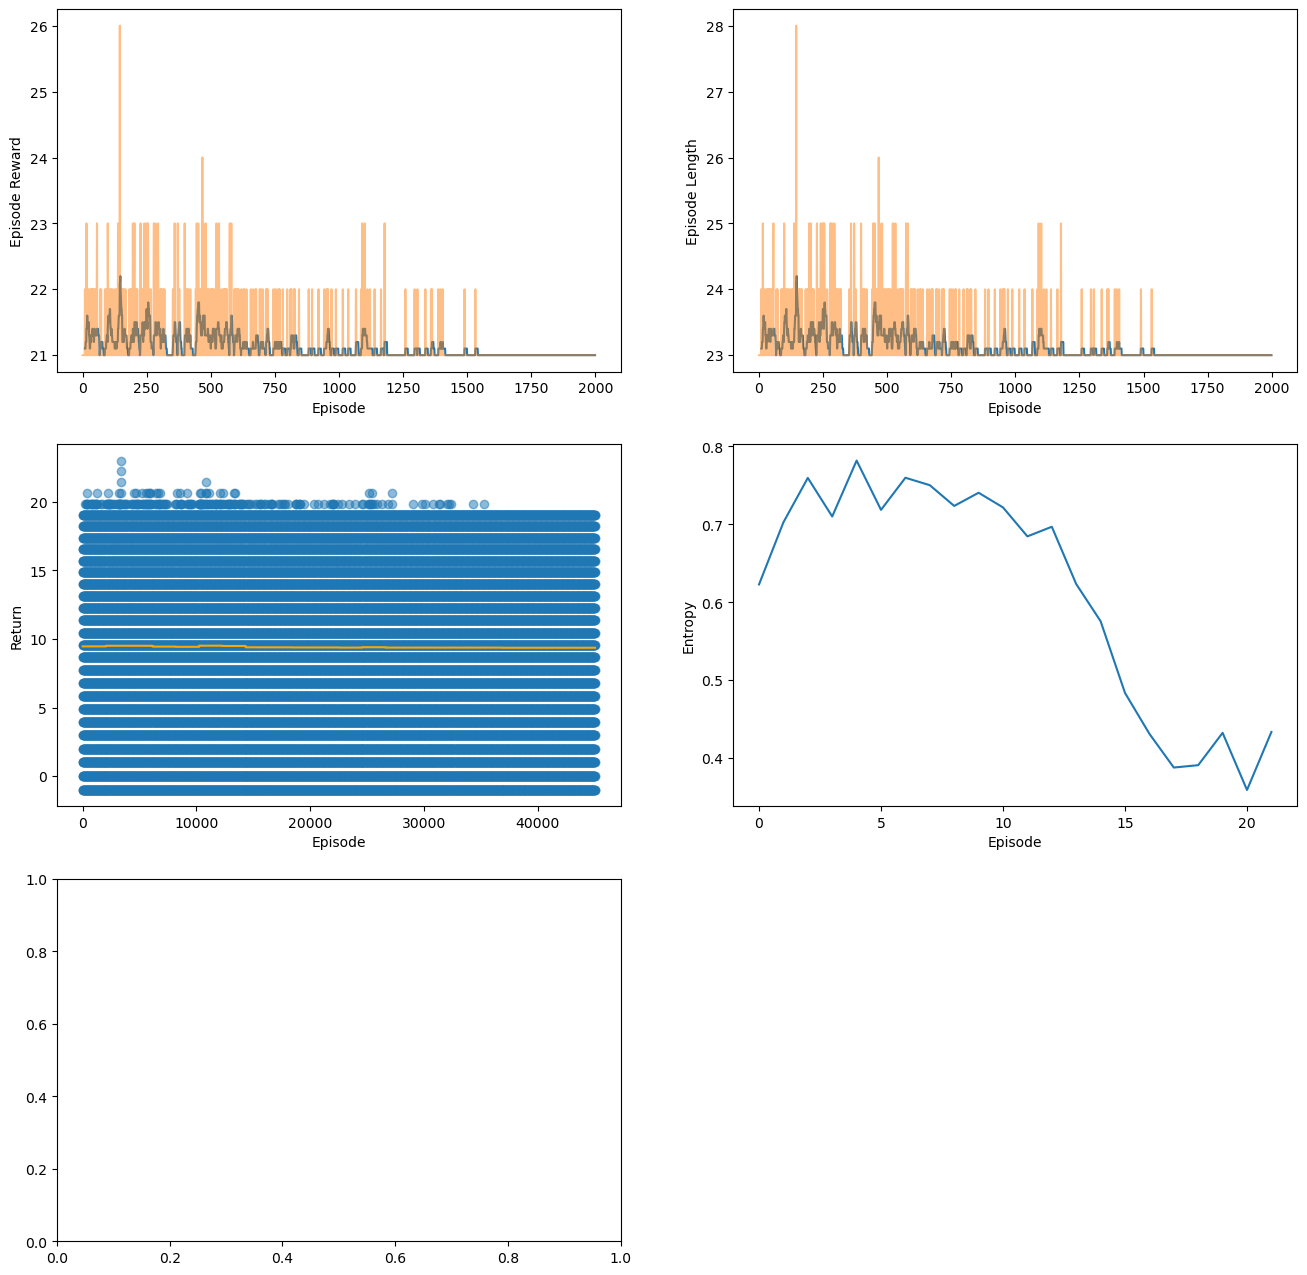

In [115]:
plot_results(runner)